In [1]:
import gc
import os
import time
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from scipy import stats
from scipy.signal import hann
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from scipy.signal import convolve
from sklearn.svm import NuSVR, SVR
from catboost import CatBoostRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold,StratifiedKFold, RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import Ridge
warnings.filterwarnings("ignore")
from typing import TypeVar, List, Dict, Tuple
PandasDataFrame = TypeVar('pandas.core.frame.DataFrame')

# Refs: https://www.kaggle.com/byfone/basic-feature-feat-catboost
# Refs: https://www.kaggle.com/kernels/scriptcontent/13873316/download

In [2]:
IS_LOCAL = False
if(IS_LOCAL):
    PATH="../input/LANL/"
else:
    PATH="../input/"
os.listdir(PATH)

train_X = pd.read_csv(os.path.join(PATH,'lanlfeatures198/feature_extraction_ds_train.csv'))
train_y = train_X[['time_to_failure']]

train_X = train_X.drop(train_X.columns[0], axis=1)
train_X = train_X.drop('time_to_failure', axis=1)

train_X.shape, train_y.shape

((4194, 198), (4194, 1))

In [3]:
submission = pd.read_csv(os.path.join(PATH,'LANL-Earthquake-Prediction/sample_submission.csv'), index_col='seg_id')
test_X = pd.read_csv(os.path.join(PATH,'lanlfeatures198/feature_extraction_ds_test.csv'), index_col='seg_id')
submission.shape, test_X.shape

((2624, 1), (2624, 198))

In [4]:
"""Use cross-validation (e.g., KFold)"""
def fold_generator(x, y, groups=None, num_folds=10, shuffle=True, seed=2019):
    folds = KFold(num_folds, shuffle=shuffle, random_state=seed)
    for train_index, test_index in folds.split(x, y, groups):
        yield train_index, test_index

In [5]:
"""Perform transforms and return final estimator"""
def make_pipeline(estimator):
    pipeline = Pipeline([
        # Each item is a tuple with a name and a transformer or estimator
        ('scaler', StandardScaler()),
        ('model', estimator)
    ])
    return pipeline

In [6]:
"""Search the hyperparameters and return the estimator with the best parameters"""
def search_cv(x, y, pipeline, grid, max_iter=None, num_folds=10, shuffle=True):
    t0 = time.time()
    
    cv = fold_generator(x, y, num_folds=num_folds)
    if max_iter is None:
        # Exhaustive search over specified parameter values for an estimator (pipeline)
        search = GridSearchCV(pipeline, grid, cv=cv,
                              scoring='neg_mean_absolute_error')
    else:
        # Randomized search on hyper parameters with 
        # The number of parameter settings that are tried is given by n_iter (not all parameter values are tried out)
        search = RandomizedSearchCV(pipeline, grid, n_iter=max_iter, cv=cv,
                                    scoring='neg_mean_absolute_error')
    search.fit(x, y)
    
    t0 = time.time() - t0
    print("Best CV score: {:.4f}, time: {:.1f}s".format(-search.best_score_, t0))
    print(search.best_params_)
    return search.best_estimator_

In [7]:
"""Train, make predictions & plot results"""
def make_predictions(x, y, pipeline, num_folds=10, shuffle=True, test=None, plot=True):
    if test is not None:
        sub_prediction = np.zeros(test.shape[0])
        
    oof_prediction = np.zeros(x.shape[0])
    # use cross-validation (10-fold cross-validation)
    for tr_idx, val_idx in fold_generator(x, y, num_folds=num_folds):
        pipeline.fit(x.iloc[tr_idx], y.iloc[tr_idx])
        oof_prediction[val_idx] = pipeline.predict(x.iloc[val_idx])

        if test is not None:
            sub_prediction += pipeline.predict(test) / num_folds
    
    if plot:
        plot_predictions(y, oof_prediction)
    if test is None:
        return oof_prediction
    else:
        return oof_prediction, sub_prediction

In [8]:
def plot_predictions(y, oof_predictions):
    """Plot out-of-fold predictions vs actual values."""
    fig, axis = plt.subplots(1, 2, figsize=(14, 6))
    ax1, ax2 = axis
    ax1.set_xlabel('actual')
    ax1.set_ylabel('predicted')
    ax1.set_ylim([-5, 20])
    ax2.set_xlabel('train index')
    ax2.set_ylabel('time to failure')
    ax2.set_ylim([-2, 18])
    ax1.scatter(y, oof_predictions, color='brown')
    ax1.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)], color='blue')
    ax2.plot(y, color='blue', label='y_train')
    ax2.plot(oof_predictions, color='orange')

Best CV score: 2.2705, time: 580.4s
{'model__learning_rate': 0.03637323232323233}


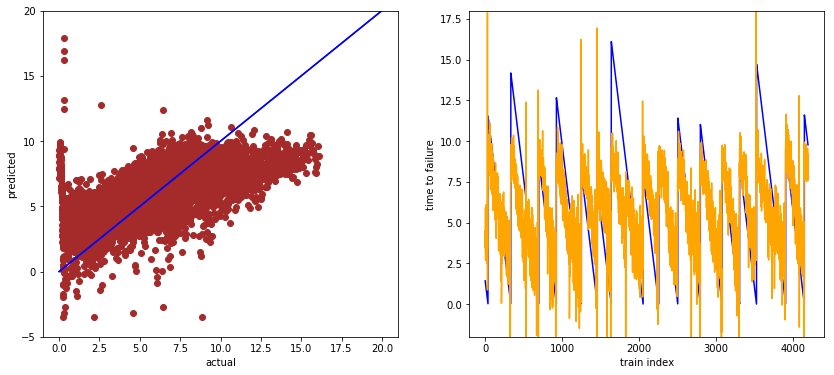

In [9]:
grid = {'model__learning_rate': np.linspace(1e-5, 0.9, 100)}
#base = DecisionTreeRegressor(max_depth=5)
base = Ridge(alpha=2)

ada_pipe = make_pipeline(AdaBoostRegressor(base_estimator=base, n_estimators=200))
ada_pipe = search_cv(train_X, train_y, ada_pipe, grid, max_iter=30)
ada_oof = make_predictions(train_X, train_y, ada_pipe)

In [10]:
ada_oof, ada_sub = make_predictions(train_X, train_y, ada_pipe,
                                  test=test_X, plot=False)

In [11]:
submission.time_to_failure = ada_sub
submission.to_csv('submission.csv',index=True)